------
------
>>>> # <center>**Sentiment Analysis of IMDb Movie Reviews Using Machine Learning**
------
------

## **Background and Introduction**


Sentiment analysis is a fundamental task in natural language processing (NLP), commonly used to analyze opinions, reviews, and social media content. By classifying texts into positive, neutral, or negative sentiments, businesses can derive valuable insights to improve customer satisfaction, understand user behavior, and predict trends.

This project focuses on performing sentiment analysis on IMDb movie reviews, where the goal is to classify each review as either positive or negative. This task holds significant importance in industries like entertainment, retails and manufacturing, where sentiment analysis helps filmmakers, producers, and distributors understand public perception and feedback.

We will use various machine learning models, feature engineering techniques, and visualization methods to explore the dataset and derive insights. Our goal is to build the best-performing machine learning model that can be deployed in real-time to predict the sentiment of a movie review.

## **Project Scope:**

The project aims to classify IMDb movie reviews as either positive or negative using several machine learning techniques. We will begin with Exploratory Data Analysis (EDA) to understand the data and then proceed to feature engineering using various NLP techniques. Next, we will implement multiple machine learning models and evaluate their performance based on accuracy, F1 score,  and ROC-curve. Finally, we will choose the best-performing model for potential real-time deployment.

**Key Tasks:**

- **Data Acquisition:** Using the Hugging Face datasets library to load the IMDB dataset..

- **Data Preprocessing:** Understanding the distribution of the data, review lengths, and relationships between features, including tokenization, stopword removal, lemmatization, and BERT embeddings.

- **Exploratory Data Analysis (EDA):** Visualizing sentiment distribution, word frequencies, n-grams, and generating word clouds.

- **Feature Engineering:** Extracting meaningful features using techniques like Count Vectors, TF-IDF, BERT embeddings, and Part-of-Speech (POS) tagging..

- **Model Selection and Training:** Training multiple machine learning models, including Naive Bayes, Logistic Regression, SVM, Random Forest, Gradient Boosting, LightGBM, Bagging, Boosting, and Stacking.

- **Model Evaluation:** Evaluating models using accuracy, F1 score, ROC curves, and learning curves..

- **Conclusions and Recommendations:** Summarizing findings and proposing further improvements.

### **Dataset Information**

The [dataset](https://huggingface.co/datasets/jahjinx/IMDb_movie_reviews) consists of 50,000 IMDb movie reviews. Each review has been labeled as either positive (1) or negative (0), providing a balanced set of reviews that can be used to train, validate, and test our models.

**Dataset Overview:**

* > Total Reviews: 50,000
* >Text: The full content of the movie review* 
* >Label: Binary sentiment label — 1 for positive reviews and 0 for negative reviews.

**Train and Test Splits:**

* We will use a portion of the dataset for training (10,000 reviews) and a smaller portion for testing (2,000 reviews) to optimize model efficiency.

* We will explore different feature sets, such as Count Vectors, TF-IDF Features (Word-level, N-gram, Character-level), and combined feature sets to evaluate model performance.

### **Importing Libraries**

In [16]:

# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from scipy.sparse import hstack

# NLP Libraries
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from bs4 import BeautifulSoup

from nltk import ngrams

# Hugging Face and Transformers
# from datasets import load_dataset
from transformers import BertTokenizer, BertModel

# Sklearn Libraries for Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

# TensorFlow/Keras for Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import  models, layers
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
from nltk import bigrams as nltk_bigrams
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
import torch

# Word Cloud
from wordcloud import WordCloud

### **Data Acquisition**

We are acquiring the dataset from HuggingFace. We choose 10,000 samples from the training data and 2,000 samples from the test data for efficiency.

In [3]:
# Load IMDb dataset from HuggingFace
splits = {'train': 'IMDB_train.csv', 'validation': 'IMDB_validation.csv', 'test': 'IMDB_test.csv'}

df_train = pd.read_csv("hf://datasets/jahjinx/IMDb_movie_reviews/" + splits["train"])
df_test = pd.read_csv("hf://datasets/jahjinx/IMDb_movie_reviews/" + splits["test"])

# Randomly sample 10,000 rows from training and 2,000 rows from the test set
df_train = df_train.sample(10000, random_state=42)
df_test = df_test.sample(2000, random_state=42)

# Define X (features) and y (target) for both train and test sets
X_train = df_train['text']
y_train = df_train['label']
X_test = df_test['text']
y_test = df_test['label']

# Check the shape of the data
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


Train set: (10000,), Test set: (2000,)


> X_train and X_test contain raw text reviews, while y_train and y_test are the target labels (positive or negative).

### **Importing NLTK data**

In [4]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/seif/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/seif/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/seif/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df_train.label.value_counts()

label
0    5023
1    4977
Name: count, dtype: int64

### **Class Distribution**

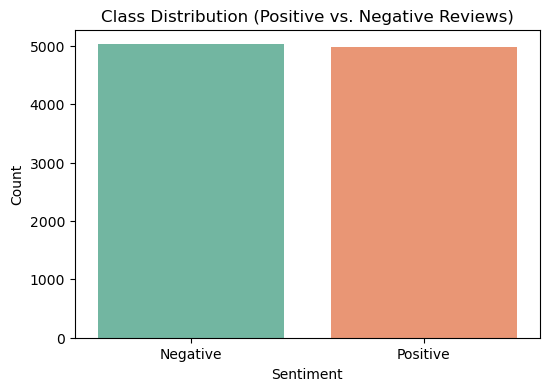

In [6]:
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, palette='Set2')
plt.title('Class Distribution (Positive vs. Negative Reviews)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()



In [7]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Cleaning function for HTML tags, stop words, and other artifacts
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Remove special characters and digits
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside square brackets
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words with digits
    
    # Tokenization and lowercasing
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords, punctuation, and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    
    # Join the tokens back into a string
    return ' '.join(tokens)

# Apply the cleaning function to the dataset
df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)

# Check the first few cleaned rows
print(df_train[['text', 'cleaned_text']].head())

/tmp/ipykernel_380106/626332142.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


                                                    text  \
16461  It's a tale that could have taken place anywhe...   
23579  I first saw this movie as a pre-teen, about th...   
23640  This definitely the most tension filled X-File...   
25635  I'm surprised this movie is rated so highly, a...   
8840   This movie is finally out on DVD in Italy (com...   

                                            cleaned_text  
16461  tale could taken place anywhere really given r...  
23579  first saw movie age kid start think identity g...  
23640  definitely tension filled episode first season...  
25635  surprised movie rated highly although go typic...  
8840   movie finally dvd italy completely restored se...  


### **Word Cloud for Positive and Negative Reviews**

A Word Cloud is a visual representation of the most common words in positive and negative reviews, with word size indicating frequency.

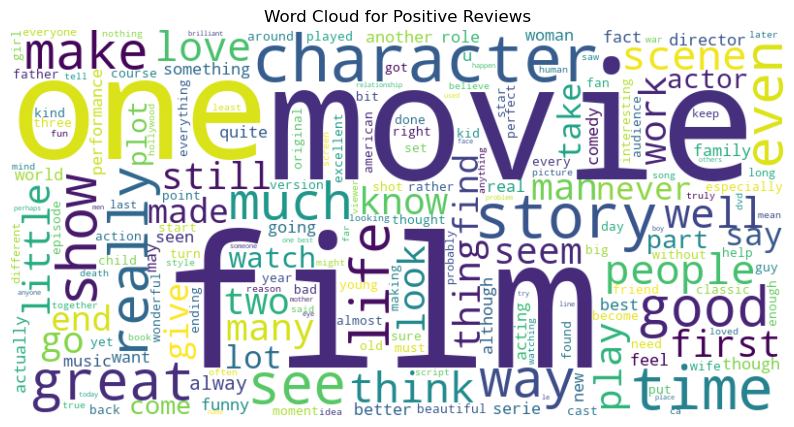

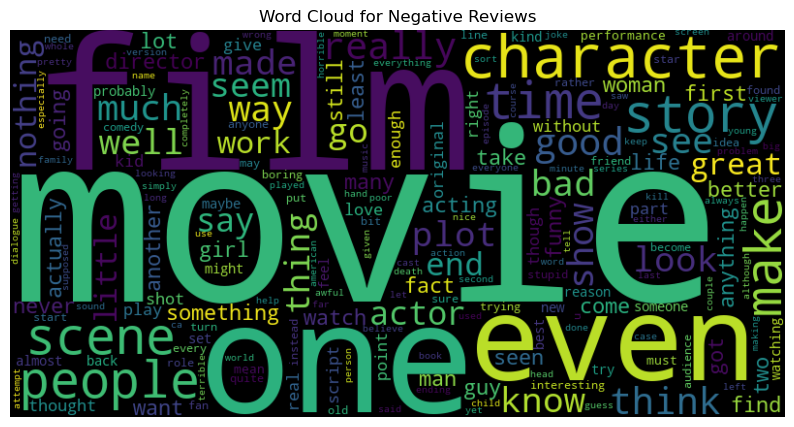

CPU times: user 5.84 s, sys: 228 ms, total: 6.06 s
Wall time: 6.06 s


In [9]:
%%time
# Word cloud for positive reviews
positive_reviews = ' '.join(df_train[df_train['label'] == 1]['cleaned_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Plot the word cloud for positive reviews
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Word cloud for negative reviews
negative_reviews = ' '.join(df_train[df_train['label'] == 0]['cleaned_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)

# Plot the word cloud for negative reviews
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


* > Both word clouds highlight the central importance of movie, film, character, and story in the reviews.

* > Positive reviews focus more on emotional and qualitative descriptors (e.g., great, fun, wonderful), while negative reviews emphasize poor quality or dissatisfaction (e.g., boring, bad, awful).

* > The prominence of terms like actor, scene, and dialogue in negative reviews suggests that technical aspects of filmmaking are often points of criticism when viewers are displeased.

### **Distribution of Review Lengths**

/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


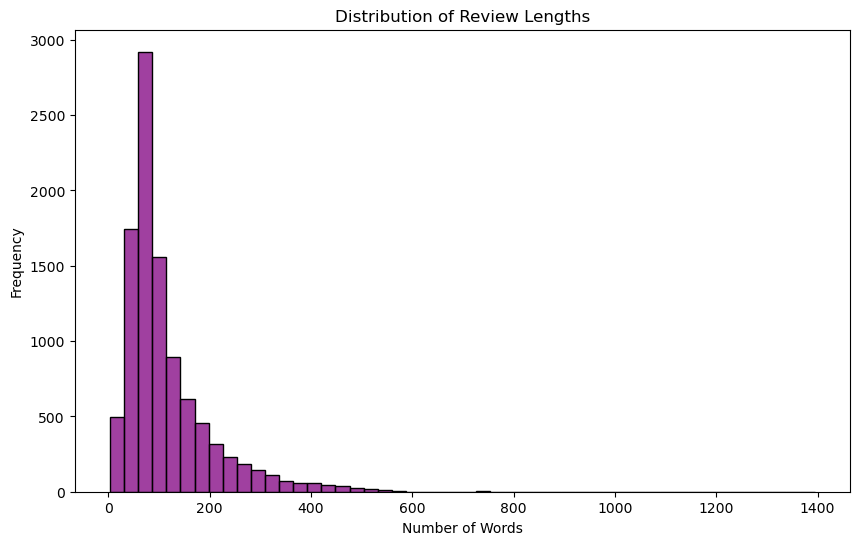

In [12]:
# Calculate the length of each review
df_train['review_length'] = df_train['cleaned_text'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df_train['review_length'], bins=50, color='purple')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

> * The histogram shows a right-skewed distribution, where the majority of reviews have a length of fewer than 200 words.

> * This indicates that most users tend to write short reviews, with only a few longer reviews extending beyond 400 words.

### **Top 10 Most Frequent Words**

/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


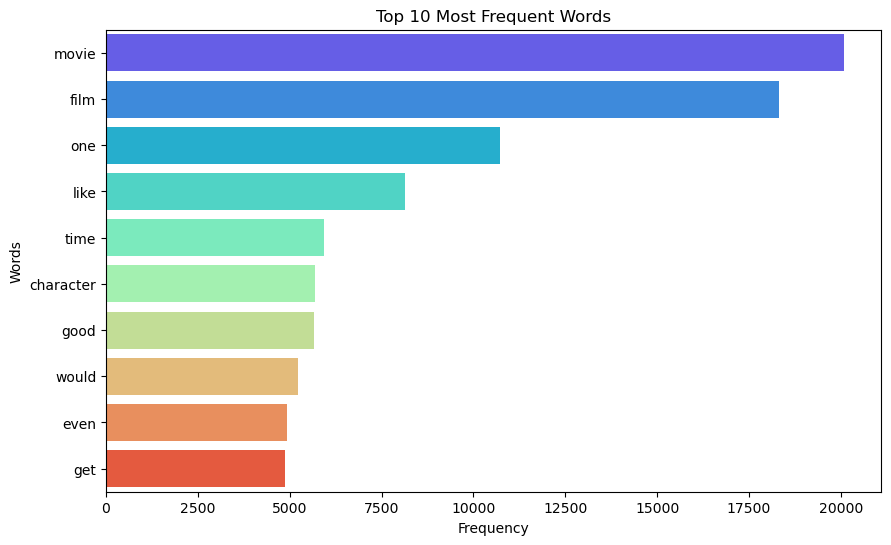

In [13]:
# Tokenize the cleaned reviews
df_train['tokens'] = df_train['cleaned_text'].apply(lambda x: x.split())

# Get the most common words
most_common_words = Counter([word for tokens in df_train['tokens'] for word in tokens]).most_common(10)

# Visualize the most common words
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette="rainbow")
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()



**High Frequency of "movie" and "film":**
- Unsurprisingly, the words "movie" and "film" are the two most frequent words in the dataset. This indicates that reviewers frequently refer to the medium itself when sharing their thoughts. These are expected terms for a movie review dataset.

**Common Words like "one", "like", and "time":**
- Words like "one," "like," and "time" are quite frequent. These words could be related to the narrative ("one" referring to characters or plot points), "like" indicating opinions or preferences, and "time" referring to elements of the movie like pacing or runtime.

**Character and Story Focus:**
- The word "character" also appears frequently, showing that reviews often discuss the role and performance of characters, which can be a significant factor in movie reviews.

**Sentiment Words:**
- Words like "good," "get," and "would" appear relatively often, possibly indicating a neutral or positive leaning in many reviews. These words may reflect general expressions of sentiment or recommendation.

### **Bigrams (Most Common Word Pairs)**

Bigrams show the most common pairs of words, helping us understand word associations in the reviews.

/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


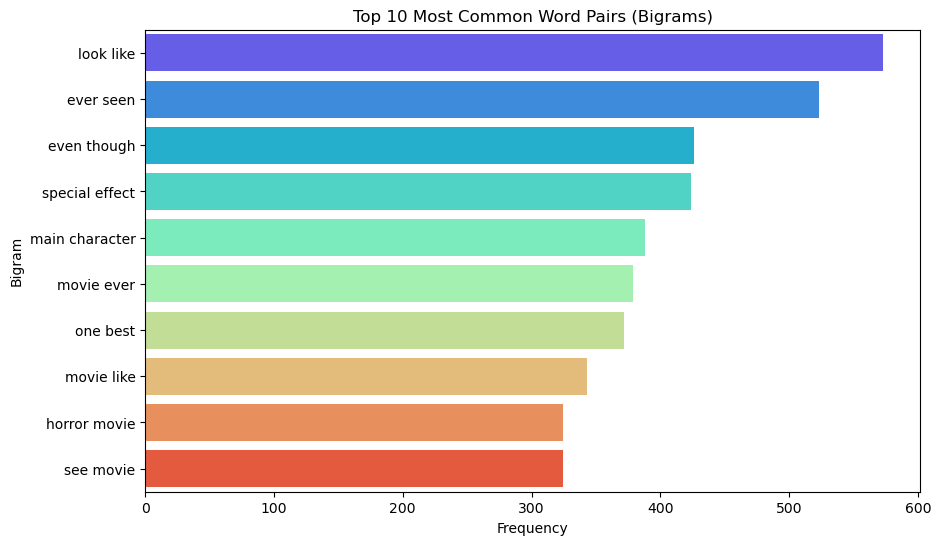

In [17]:
# Generate bigrams from the tokenized words
bigram_list = list(bigrams([word for tokens in df_train['tokens'] for word in tokens]))

# Count the frequency of each bigram
bigram_counts = Counter(bigram_list)

# Get the 10 most common bigrams
common_bigrams = bigram_counts.most_common(10)

# Convert the common bigrams to a DataFrame for plotting
bigram_df = pd.DataFrame(common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y=[' '.join(bigram) for bigram in bigram_df['Bigram']], data=bigram_df, palette='rainbow')
plt.title('Top 10 Most Common Word Pairs (Bigrams)')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()


* > Many of the bigrams suggest strong emotional responses, comparisons with other films, and a focus on technical or specific aspects like "special effects" and "main character."

* > The reviews seem to contain a mix of subjective opinions (e.g., "best movie ever") and objective assessments (e.g., "special effect"), reflecting varied criteria used by the reviewers to judge the films.

* > The appearance of "horror movie" suggests that the dataset may have a notable number of reviews related to that genre, or that genre-specific elements are important in the reviews.

### **Text Preprocessing**

We use tokenization, stop-word removal, and lemmatization to convert raw text into meaningful tokens while keeping only important words. This step improves model performance by reducing noise in the data.

In [4]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text Preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize text and convert to lowercase
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(tokens)

# Apply preprocessing to the training and test data
df_train['processed_text'] = X_train.apply(preprocess_text)
df_test['processed_text'] = X_test.apply(preprocess_text)

# Display a sample of the processed text
print(df_train['processed_text'].head())


[nltk_data] Downloading package punkt to /home/seif/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/seif/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/seif/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


16461    tale could taken place anywhere really given r...
23579    first saw movie age kid start think identity g...
23640    definitely tension filled episode first season...
25635    surprised movie rated highly although go typic...
8840     movie finally dvd italy completely restored se...
Name: processed_text, dtype: object


> Tokenization breaks down text into individual words (tokens).

> Lemmatization converts words to their base forms (e.g., "running" to "run"), reducing vocabulary size.

> Stop-word removal eliminates common words ("the", "is", etc.) that don't contribute to sentiment classification.

### **Feature Extraction**

Next, we extract various types of features to train models.

### **Count Vectors**

Count Vectorizer transforms text into a matrix of token counts. This is one of the simplest ways to represent text.

In [5]:
# Count Vectorizer (word count-based)
count_vect = CountVectorizer(max_features=5000, stop_words='english')
X_train_count = count_vect.fit_transform(df_train['processed_text'])
X_test_count = count_vect.transform(df_test['processed_text'])

# Check the shape of the resulting matrix
print(f"Count Vectors Shape: {X_train_count.shape}")


Count Vectors Shape: (10000, 5000)


### **TF-IDF (Word-Level, N-Gram, and Character-Level)**

Explanation: TF-IDF (Term Frequency-Inverse Document Frequency) gives more importance to rare words while down-weighting common words.

In [80]:
%%time
# Word-level TF-IDF
tfidf_vect_word = TfidfVectorizer(analyzer='word', max_features=5000)
X_train_tfidf_word = tfidf_vect_word.fit_transform(df_train['processed_text'])
X_test_tfidf_word = tfidf_vect_word.transform(df_test['processed_text'])

# N-Gram level TF-IDF (bi-grams and tri-grams)
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(2, 3), max_features=5000)
X_train_tfidf_ngram = tfidf_vect_ngram.fit_transform(df_train['processed_text'])
X_test_tfidf_ngram = tfidf_vect_ngram.transform(df_test['processed_text'])

# Character-level TF-IDF
tfidf_vect_char = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=5000)
X_train_tfidf_char = tfidf_vect_char.fit_transform(df_train['processed_text'])
X_test_tfidf_char = tfidf_vect_char.transform(df_test['processed_text'])


CPU times: user 12.6 s, sys: 112 ms, total: 12.7 s
Wall time: 12.7 s


In [26]:
# Check the shapes
print(f"Word-level TF-IDF shape (train): {X_train_tfidf_word.shape}, (test): {X_test_tfidf_word.shape}")
print(f"N-Gram TF-IDF shape (train): {X_train_tfidf_ngram.shape}, (test): {X_test_tfidf_ngram.shape}")
print(f"Char-level TF-IDF shape (train): {X_train_tfidf_char.shape}, (test): {X_test_tfidf_char.shape}")


Word-level TF-IDF shape (train): (10000, 5000), (test): (2000, 5000)
N-Gram TF-IDF shape (train): (10000, 5000), (test): (2000, 5000)
Char-level TF-IDF shape (train): (10000, 5000), (test): (2000, 5000)


> Word-level TF-IDF captures the importance of individual words.

> N-gram TF-IDF captures word pairs or triples to account for phrases.

> Character-level TF-IDF captures important sub-word information like suffixes or word shapes.

### **Text/NLP-Based Features**

Explanation: We extract additional features such as word count, character count, punctuation count, etc., to give the model a better understanding of the text structure.

In [7]:
# Additional text features
df_train['char_count'] = df_train['text'].apply(len)
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))
df_train['word_density'] = df_train['char_count'] / (df_train['word_count'] + 1)
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([p for p in x if p in string.punctuation]))
df_train['title_word_count'] = df_train['text'].apply(lambda x: len([w for w in x.split() if w.istitle()]))
df_train['uppercase_word_count'] = df_train['text'].apply(lambda x: len([w for w in x.split() if w.isupper()]))

df_test['char_count'] = df_test['text'].apply(len)
df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))
df_test['word_density'] = df_test['char_count'] / (df_test['word_count'] + 1)
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([p for p in x if p in string.punctuation]))
df_test['title_word_count'] = df_test['text'].apply(lambda x: len([w for w in x.split() if w.istitle()]))
df_test['uppercase_word_count'] = df_test['text'].apply(lambda x: len([w for w in x.split() if w.isupper()]))


> These features capture structural elements of text, such as word length, punctuation, and uppercase words, which may correlate with the review's sentiment.

### **POS Tagging**

Part-of-speech (POS) tagging identifies different grammatical elements like adjectives, adverbs, nouns, and verbs. We count these elements to provide the model with more syntactic information.

In [8]:
%%time
# Initialize columns for part-of-speech (POS) features
df_train['adj_count'] = 0
df_train['adv_count'] = 0
df_train['noun_count'] = 0
df_train['verb_count'] = 0
df_train['pron_count'] = 0

pos_mapping = {
    'JJ': 'adj_count', 'JJR': 'adj_count', 'JJS': 'adj_count',
    'RB': 'adv_count', 'RBR': 'adv_count', 'RBS': 'adv_count',
    'NN': 'noun_count', 'NNS': 'noun_count',
    'VB': 'verb_count', 'VBD': 'verb_count', 'VBG': 'verb_count',
    'VBN': 'verb_count', 'VBP': 'verb_count', 'VBZ': 'verb_count',
    'PRP': 'pron_count', 'PRP$': 'pron_count', 'WP': 'pron_count', 'WP$': 'pron_count'
}

# Apply POS tagging with NLTK
for i, text in enumerate(df_train['text']):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    pos_counts = Counter([pos for word, pos in pos_tags])
    for pos_tag, count in pos_counts.items():
        if pos_tag in pos_mapping:
            df_train.iloc[i, df_train.columns.get_loc(pos_mapping[pos_tag])] += count

# Repeat for the test set
df_test['adj_count'] = 0
df_test['adv_count'] = 0
df_test['noun_count'] = 0
df_test['verb_count'] = 0
df_test['pron_count'] = 0

for i, text in enumerate(df_test['text']):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    pos_counts = Counter([pos for word, pos in pos_tags])
    for pos_tag, count in pos_counts.items():
        if pos_tag in pos_mapping:
            df_test.iloc[i, df_test.columns.get_loc(pos_mapping[pos_tag])] += count

# Convert POS counts to arrays
pos_train = df_train[['adj_count', 'adv_count', 'noun_count', 'verb_count', 'pron_count']].values
pos_test = df_test[['adj_count', 'adv_count', 'noun_count', 'verb_count', 'pron_count']].values


CPU times: user 1min 59s, sys: 106 ms, total: 2min
Wall time: 2min


> POS tagging gives the model more syntactic understanding, as adjectives or adverbs might indicate sentiment (e.g., "excellent", "poor").

### **BERT Tokenization and Embeddings**

BERT embeddings capture semantic information from text using a pretrained model, providing rich context for the text that other methods may miss.

In [11]:
%%time
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to generate BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply BERT embeddings
df_train['bert_embeddings'] = df_train['text'].apply(get_bert_embedding)
df_test['bert_embeddings'] = df_test['text'].apply(get_bert_embedding)

# Convert BERT embeddings to numpy arrays
X_train_bert = np.vstack(df_train['bert_embeddings'])
X_test_bert = np.vstack(df_test['bert_embeddings'])


CPU times: user 2h 11min 55s, sys: 22.5 s, total: 2h 12min 17s
Wall time: 22min 4s


> BERT embeddings capture deeper contextual meanings from text that bag-of-words models (e.g., Count Vectorizer) can’t. They encode the relationship between words based on the entire sentence.

### **Topic Modeling (LDA)**

Latent Dirichlet Allocation (LDA) is used to extract topics from the text. Each review is represented by a topic distribution.


In [20]:
%%time
# LDA for topic modeling on count vectors
lda_model = LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics_train = lda_model.fit_transform(X_train_count)
X_topics_test = lda_model.transform(X_test_count)


CPU times: user 50.1 s, sys: 0 ns, total: 50.1 s
Wall time: 50.1 s


> Topic modeling helps group reviews into different topics (e.g., plot, acting, etc.), which can help identify sentiment patterns related to specific topics.

### **Combine All Features**

We now combine all features (Count Vectors, TF-IDF, BERT embeddings, POS, and LDA topics) into a single feature matrix for training and testing.

In [21]:
%%time
# Combine all features into one matrix for both train and test sets
X_train_combined = hstack([X_train_count, X_train_tfidf_word, X_train_tfidf_ngram, X_train_tfidf_char, X_topics_train, np.array(pos_train)])
X_test_combined = hstack([X_test_count, X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char, X_topics_test, np.array(pos_test)])


CPU times: user 72.8 ms, sys: 7.94 ms, total: 80.8 ms
Wall time: 80.9 ms


> Combining all feature sets ensures that we capture both surface-level and deep semantic meanings from the text.

## **Model Selection and Training Rationale**

> Next, we will train and evaluate six models using three feature sets: 
* Count Vectors, 
* TF-IDF Features, and
* Combined Features

> **The models we will be training are:**

* Naive Bayes
* Logistic Regression
* Support Vector Machine
* Random Forest
* Gradient Boosting
* Light Gradient Boosting

### **Initializing a dataframe for overall model performance metrics**

In [59]:
# Initialize the DataFrame
results_df = pd.DataFrame(columns=[
    'Model', 
    'Count Vectors Accuracy', 'Count Vectors F1 Score',
    'TF-IDF Features Accuracy', 'TF-IDF Features F1 Score',
    'Combined Features Accuracy', 'Combined Features F1 Score'
])

##  **Naive Bayes**
Naive Bayes works well for text classification because it assumes that the presence of a particular feature (word) is independent of the presence of any other feature (i.e., conditional independence assumption). It’s fast and effective for high-dimensional datasets like text.

We’ll use Multinomial Naive Bayes, which is a variant designed for text data.

### **Training Naive Bayes on Count Vectors**


In [23]:
%%time
# Train Naive Bayes on Count Vectors
nb_model_count = MultinomialNB()
nb_model_count.fit(X_train_count, y_train)
y_pred_nb_count = nb_model_count.predict(X_test_count)

# Evaluate the model
accuracy_nb_count = accuracy_score(y_test, y_pred_nb_count)
f1_nb_count = f1_score(y_test, y_pred_nb_count)

print(f"Naive Bayes - Count Vectors Accuracy: {accuracy_nb_count:.4f}")
print(f"Naive Bayes - Count Vectors F1 Score: {f1_nb_count:.4f}")


Naive Bayes - Count Vectors Accuracy: 0.8465
Naive Bayes - Count Vectors F1 Score: 0.8449
CPU times: user 9.33 ms, sys: 4 µs, total: 9.34 ms
Wall time: 8.57 ms


In [27]:
# Train Naive Bayes on Count Vectors
nb_model_count = MultinomialNB()
nb_model_count.fit(X_train_count, y_train)
y_pred_nb_count = nb_model_count.predict(X_test_count)

# Evaluate the model
accuracy_nb_count = accuracy_score(y_test, y_pred_nb_count)
f1_nb_count = f1_score(y_test, y_pred_nb_count)

print(f"Naive Bayes - Count Vectors Accuracy: {accuracy_nb_count:.4f}")
print(f"Naive Bayes - Count Vectors F1 Score: {f1_nb_count:.4f}")


Naive Bayes - Count Vectors Accuracy: 0.8465
Naive Bayes - Count Vectors F1 Score: 0.8449


### **Training Naive Bayes on TF-IDF Vectors**

In [28]:
%%time
# Train Naive Bayes on TF-IDF Features
nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(hstack([X_train_tfidf_word, X_train_tfidf_ngram, X_train_tfidf_char]), y_train)
y_pred_nb_tfidf = nb_model_tfidf.predict(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))

# Evaluate the model
accuracy_nb_tfidf = accuracy_score(y_test, y_pred_nb_tfidf)
f1_nb_tfidf = f1_score(y_test, y_pred_nb_tfidf)

print(f"Naive Bayes - TF-IDF Features Accuracy: {accuracy_nb_tfidf:.4f}")
print(f"Naive Bayes - TF-IDF Features F1 Score: {f1_nb_tfidf:.4f}")



Naive Bayes - TF-IDF Features Accuracy: 0.8655
Naive Bayes - TF-IDF Features F1 Score: 0.8676
CPU times: user 65.7 ms, sys: 20 ms, total: 85.7 ms
Wall time: 85 ms


### **Training Naive Bayes on Combined Features**


In [29]:
%%time
# Train Naive Bayes on Combined Features
nb_model_combined = MultinomialNB()
nb_model_combined.fit(X_train_combined, y_train)
y_pred_nb_combined = nb_model_combined.predict(X_test_combined)

# Evaluate the model
accuracy_nb_combined = accuracy_score(y_test, y_pred_nb_combined)
f1_nb_combined = f1_score(y_test, y_pred_nb_combined)

print(f"Naive Bayes - Combined Features Accuracy: {accuracy_nb_combined:.4f}")
print(f"Naive Bayes - Combined Features F1 Score: {f1_nb_combined:.4f}")




Naive Bayes - Combined Features Accuracy: 0.8465
Naive Bayes - Combined Features F1 Score: 0.8460
CPU times: user 421 ms, sys: 12 ms, total: 433 ms
Wall time: 434 ms


### **Adding the results to the DataFrame**

In [61]:
# Add Naive Bayes results
nb_results = pd.DataFrame({
    'Model': ['Naive Bayes'],
    'Count Vectors Accuracy': [accuracy_nb_count], 'Count Vectors F1 Score': [f1_nb_count],
    'TF-IDF Features Accuracy': [accuracy_nb_tfidf], 'TF-IDF Features F1 Score': [f1_nb_tfidf],
    'Combined Features Accuracy': [accuracy_nb_combined], 'Combined Features F1 Score': [f1_nb_combined]
})

# Add Naive Bayes results to the DataFrame
results_df = pd.concat([results_df, nb_results], ignore_index=True)


### **ROC Curve for Naive Bayes:**

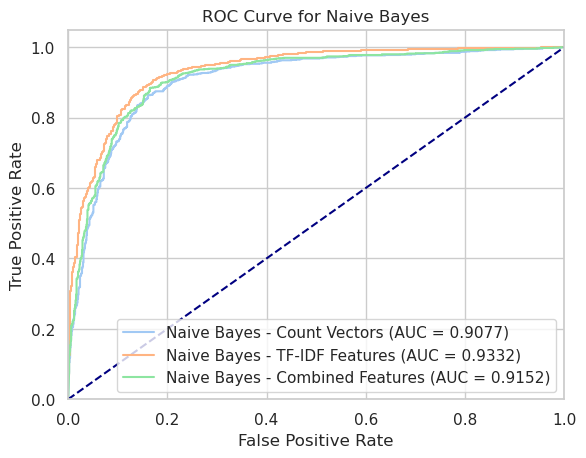

In [96]:
# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_prob, model_name, feature_set):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} - {feature_set} (AUC = {roc_auc:.4f})')

# Naive Bayes on Count Vectors
y_pred_prob_nb_count = nb_model_count.predict_proba(X_test_count)[:, 1]
plot_roc_curve(y_test, y_pred_prob_nb_count, 'Naive Bayes', 'Count Vectors')

# Naive Bayes on TF-IDF Features
y_pred_prob_nb_tfidf = nb_model_tfidf.predict_proba(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))[:, 1]
plot_roc_curve(y_test, y_pred_prob_nb_tfidf, 'Naive Bayes', 'TF-IDF Features')

# Naive Bayes on Combined Features
y_pred_prob_nb_combined = nb_model_combined.predict_proba(X_test_combined)[:, 1]
plot_roc_curve(y_test, y_pred_prob_nb_combined, 'Naive Bayes', 'Combined Features')

# Customize plot for Naive Bayes
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes')
plt.legend(loc="lower right")
plt.show()

**Observations:**

**The model's ROC curves are shown for three feature extraction methods: Count Vectors, TF-IDF Features, and Combined Features.**

> TF-IDF features (AUC = 0.9332) perform the best, followed by Combined Features (AUC = 0.9152), and Count Vectors (AUC = 0.9077).

> Overall, Naive Bayes shows fairly good performance across all feature extraction methods, but TF-IDF clearly offers the best discrimination between classes.

## **Logistic Regression**

Logistic Regression is a linear model that predicts the probability of a class (positive or negative) using a logistic function. It computes weighted sums of the input features to make predictions.
Logistic Regression is one of the most commonly used models for binary classification tasks like sentiment analysis. It works well with sparse data such as TF-IDF vectors because it handles a large number of features efficiently.

We expect Logistic Regression to perform well with TF-IDF Features because it captures linear relationships between features (word importance) and the target labels (positive or negative). It will also benefit from Combined Features.

### **Training Logistic Regression on Count Vectors**

In [30]:
%%time
# Train Logistic Regression on Count Vectors
lr_model_count = LogisticRegression(max_iter=1000)
lr_model_count.fit(X_train_count, y_train)
y_pred_lr_count = lr_model_count.predict(X_test_count)

# Evaluate the model
accuracy_lr_count = accuracy_score(y_test, y_pred_lr_count)
f1_lr_count = f1_score(y_test, y_pred_lr_count)

print(f"Logistic Regression - Count Vectors Accuracy: {accuracy_lr_count:.4f}")
print(f"Logistic Regression - Count Vectors F1 Score: {f1_lr_count:.4f}")


Logistic Regression - Count Vectors Accuracy: 0.8435
Logistic Regression - Count Vectors F1 Score: 0.8407
CPU times: user 438 ms, sys: 16 µs, total: 438 ms
Wall time: 446 ms


### **Training Logistic Regression on TF-IDF Features**

In [31]:
%%time

# Train Logistic Regression on TF-IDF Features
lr_model_tfidf = LogisticRegression(max_iter=1000)
lr_model_tfidf.fit(hstack([X_train_tfidf_word, X_train_tfidf_ngram, X_train_tfidf_char]), y_train)
y_pred_lr_tfidf = lr_model_tfidf.predict(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))

# Evaluate the model
accuracy_lr_tfidf = accuracy_score(y_test, y_pred_lr_tfidf)
f1_lr_tfidf = f1_score(y_test, y_pred_lr_tfidf)

print(f"Logistic Regression - TF-IDF Features Accuracy: {accuracy_lr_tfidf:.4f}")
print(f"Logistic Regression - TF-IDF Features F1 Score: {f1_lr_tfidf:.4f}")


Logistic Regression - TF-IDF Features Accuracy: 0.8810
Logistic Regression - TF-IDF Features F1 Score: 0.8815
CPU times: user 11.7 s, sys: 27.7 ms, total: 11.7 s
Wall time: 1.1 s


### **Training Logistic Regression on Combined Features**

In [33]:
%%time

# Train Logistic Regression on Combined Features
lr_model_combined = LogisticRegression(max_iter=5000)
lr_model_combined.fit(X_train_combined, y_train)
y_pred_lr_combined = lr_model_combined.predict(X_test_combined)

# Evaluate the model
accuracy_lr_combined = accuracy_score(y_test, y_pred_lr_combined)
f1_lr_combined = f1_score(y_test, y_pred_lr_combined)

print(f"Logistic Regression - Combined Features Accuracy: {accuracy_lr_combined:.4f}")
print(f"Logistic Regression - Combined Features F1 Score: {f1_lr_combined:.4f}")


Logistic Regression - Combined Features Accuracy: 0.8525
Logistic Regression - Combined Features F1 Score: 0.8497
CPU times: user 8min 56s, sys: 938 ms, total: 8min 57s
Wall time: 49.1 s


In [62]:
# Add Logistic Regression results
lr_results = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Count Vectors Accuracy': [accuracy_lr_count], 'Count Vectors F1 Score': [f1_lr_count],
    'TF-IDF Features Accuracy': [accuracy_lr_tfidf], 'TF-IDF Features F1 Score': [f1_lr_tfidf],
    'Combined Features Accuracy': [accuracy_lr_combined], 'Combined Features F1 Score': [f1_lr_combined]
})
results_df = pd.concat([results_df, lr_results], ignore_index=True)


### **ROC Curve for Logistic Regression:**

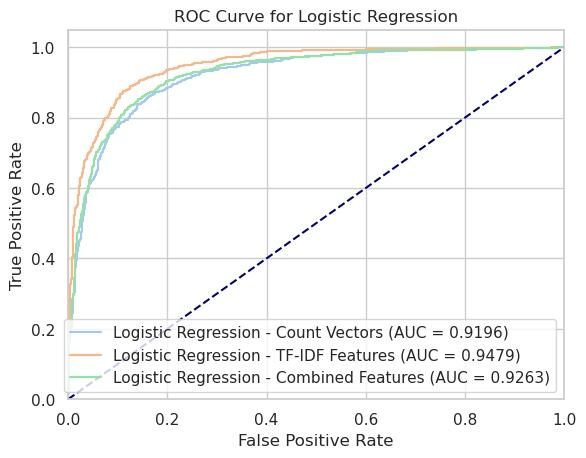

In [97]:
# Logistic Regression on Count Vectors
y_pred_prob_lr_count = lr_model_count.predict_proba(X_test_count)[:, 1]
plot_roc_curve(y_test, y_pred_prob_lr_count, 'Logistic Regression', 'Count Vectors')

# Logistic Regression on TF-IDF Features
y_pred_prob_lr_tfidf = lr_model_tfidf.predict_proba(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))[:, 1]
plot_roc_curve(y_test, y_pred_prob_lr_tfidf, 'Logistic Regression', 'TF-IDF Features')

# Logistic Regression on Combined Features
y_pred_prob_lr_combined = lr_model_combined.predict_proba(X_test_combined)[:, 1]
plot_roc_curve(y_test, y_pred_prob_lr_combined, 'Logistic Regression', 'Combined Features')

# Customize plot for Logistic Regression
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()


**Observation**:

> Again, TF-IDF features (AUC = 0.9479) outperform the other two, with Combined Features (AUC = 0.9263) coming next, and Count Vectors (AUC = 0.9196) being slightly behind.

> Logistic Regression seems to perform better overall compared to Naive Bayes, particularly with TF-IDF features, indicating that it is a more effective classifier for this problem.

## **Support Vector Machine(SVM)**

SVM is a model that finds a hyperplane to separate the classes in the feature space. It tries to maximize the margin between the positive and negative classes.
SVM works well when data is high-dimensional, as is the case with text data, especially with TF-IDF Features. It’s known to be robust and effective for text classification.
SVM is expected to perform well on TF-IDF Features and Combined Features, as it excels in capturing linear boundaries in high-dimensional spaces. However, it may not perform as well with Count Vectors since those features are less complex(We can verify this on ROC-CURVE).


### **Training SVM on Count Vectors**

In [34]:
%%time
# Train SVM on Count Vectors
svm_model_count = LinearSVC(max_iter=1000)
svm_model_count.fit(X_train_count, y_train)
y_pred_svm_count = svm_model_count.predict(X_test_count)

# Evaluate the model
accuracy_svm_count = accuracy_score(y_test, y_pred_svm_count)
f1_svm_count = f1_score(y_test, y_pred_svm_count)

print(f"SVM - Count Vectors Accuracy: {accuracy_svm_count:.4f}")
print(f"SVM - Count Vectors F1 Score: {f1_svm_count:.4f}")


SVM - Count Vectors Accuracy: 0.8200
SVM - Count Vectors F1 Score: 0.8161
CPU times: user 3.3 s, sys: 0 ns, total: 3.3 s
Wall time: 3.3 s


### **Training SVM on TF-IDF Features**

In [35]:
%%time

# Train SVM on TF-IDF Features
svm_model_tfidf = LinearSVC(max_iter=1000)
svm_model_tfidf.fit(hstack([X_train_tfidf_word, X_train_tfidf_ngram, X_train_tfidf_char]), y_train)
y_pred_svm_tfidf = svm_model_tfidf.predict(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))

# Evaluate the model
accuracy_svm_tfidf = accuracy_score(y_test, y_pred_svm_tfidf)
f1_svm_tfidf = f1_score(y_test, y_pred_svm_tfidf)

print(f"SVM - TF-IDF Features Accuracy: {accuracy_svm_tfidf:.4f}")
print(f"SVM - TF-IDF Features F1 Score: {f1_svm_tfidf:.4f}")


SVM - TF-IDF Features Accuracy: 0.8635
SVM - TF-IDF Features F1 Score: 0.8615
CPU times: user 667 ms, sys: 24 ms, total: 691 ms
Wall time: 690 ms


### **Training SVM on Combined Features**

In [39]:
%%time

# Train SVM on Combined Features
svm_model_combined = LinearSVC(max_iter=50000)
svm_model_combined.fit(X_train_combined, y_train)
y_pred_svm_combined = svm_model_combined.predict(X_test_combined)

# Evaluate the model
accuracy_svm_combined = accuracy_score(y_test, y_pred_svm_combined)
f1_svm_combined = f1_score(y_test, y_pred_svm_combined)

print(f"SVM - Combined Features Accuracy: {accuracy_svm_combined:.4f}")
print(f"SVM - Combined Features F1 Score: {f1_svm_combined:.4f}")


SVM - Combined Features Accuracy: 0.8325
SVM - Combined Features F1 Score: 0.8288
CPU times: user 5min 14s, sys: 48.6 ms, total: 5min 14s
Wall time: 5min 14s


/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [63]:
# Add SVM results
svm_results = pd.DataFrame({
    'Model': ['SVM'],
    'Count Vectors Accuracy': [accuracy_svm_count], 'Count Vectors F1 Score': [f1_svm_count],
    'TF-IDF Features Accuracy': [accuracy_svm_tfidf], 'TF-IDF Features F1 Score': [f1_svm_tfidf],
    'Combined Features Accuracy': [accuracy_svm_combined], 'Combined Features F1 Score': [f1_svm_combined]
})
results_df = pd.concat([results_df, svm_results], ignore_index=True)


### **ROC Curve for SVM:**

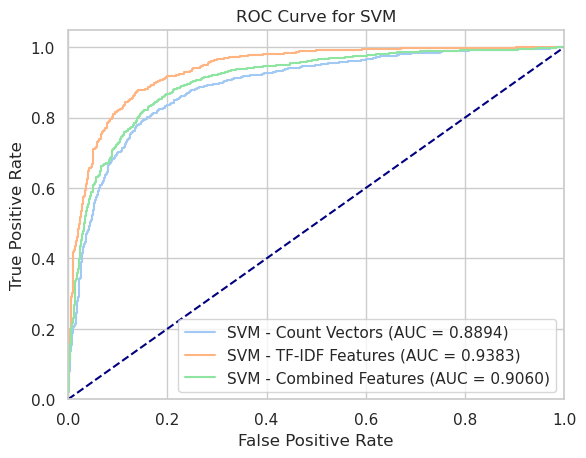

In [92]:
# SVM on Count Vectors
y_pred_prob_svm_count = svm_model_count.decision_function(X_test_count)
plot_roc_curve(y_test, y_pred_prob_svm_count, 'SVM', 'Count Vectors')

# SVM on TF-IDF Features
y_pred_prob_svm_tfidf = svm_model_tfidf.decision_function(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))
plot_roc_curve(y_test, y_pred_prob_svm_tfidf, 'SVM', 'TF-IDF Features')

# SVM on Combined Features
y_pred_prob_svm_combined = svm_model_combined.decision_function(X_test_combined)
plot_roc_curve(y_test, y_pred_prob_svm_combined, 'SVM', 'Combined Features')

# Customize plot for SVM
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.show()


**Interpretation:** 

> For the SVM model, TF-IDF features (AUC = 0.9383) yield the best results, followed by Combined Features (AUC = 0.9060), and Count Vectors (AUC = 0.8894).

> The SVM model's performance is comparable to Logistic Regression but slightly lower across all feature extraction techniques. The gap between the TF-IDF and Count Vector performances is more noticeable here.

## **Random Forest Implementation**

Random Forest is an ensemble model that builds multiple decision trees and combines their predictions. Each tree is trained on a random subset of features and data points, which helps in reducing overfitting.

Random Forest works well when there’s a need to capture non-linear relationships in the data. It’s flexible, handles a large number of features, and is robust against overfitting.

Random Forest is expected to perform better with Combined Features, where it can benefit from diverse feature sets (like BERT embeddings and TF-IDF). It might also do well on Count Vectors but could struggle with sparse TF-IDF representations.

### **Random Forest on Count Vectors**


In [40]:
%%time
# Initialize Random Forest
rf_model_count = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_count.fit(X_train_count, y_train)

# Make predictions
y_pred_rf_count = rf_model_count.predict(X_test_count)

# Evaluate the model
accuracy_rf_count = accuracy_score(y_test, y_pred_rf_count)
f1_rf_count = f1_score(y_test, y_pred_rf_count)

print(f"Random Forest - Count Vectors Accuracy: {accuracy_rf_count:.4f}")
print(f"Random Forest - Count Vectors F1 Score: {f1_rf_count:.4f}")


Random Forest - Count Vectors Accuracy: 0.8405
Random Forest - Count Vectors F1 Score: 0.8399
CPU times: user 8.68 s, sys: 18 µs, total: 8.68 s
Wall time: 8.68 s


### **Random Forest on TF-IDF Features**

In [41]:
%%time
# Random Forest on TF-IDF Features (combined word, n-gram, char-level)
rf_model_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_tfidf.fit(hstack([X_train_tfidf_word, X_train_tfidf_ngram, X_train_tfidf_char]), y_train)

# Make predictions
y_pred_rf_tfidf = rf_model_tfidf.predict(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))

# Evaluate the model
accuracy_rf_tfidf = accuracy_score(y_test, y_pred_rf_tfidf)
f1_rf_tfidf = f1_score(y_test, y_pred_rf_tfidf)

print(f"Random Forest - TF-IDF Features Accuracy: {accuracy_rf_tfidf:.4f}")
print(f"Random Forest - TF-IDF Features F1 Score: {f1_rf_tfidf:.4f}")


Random Forest - TF-IDF Features Accuracy: 0.8105
Random Forest - TF-IDF Features F1 Score: 0.8108
CPU times: user 28.1 s, sys: 12 ms, total: 28.1 s
Wall time: 28.1 s


### **Random Forest on Combined Features**

In [42]:
%%time
# Random Forest on Combined Features
rf_model_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_combined.fit(X_train_combined, y_train)

# Make predictions
y_pred_rf_combined = rf_model_combined.predict(X_test_combined)

# Evaluate the model
accuracy_rf_combined = accuracy_score(y_test, y_pred_rf_combined)
f1_rf_combined = f1_score(y_test, y_pred_rf_combined)

print(f"Random Forest - Combined Features Accuracy: {accuracy_rf_combined:.4f}")
print(f"Random Forest - Combined Features F1 Score: {f1_rf_combined:.4f}")


Random Forest - Combined Features Accuracy: 0.8310
Random Forest - Combined Features F1 Score: 0.8325
CPU times: user 28 s, sys: 12 ms, total: 28 s
Wall time: 28 s


In [64]:
# Add Random Forest results
rf_results = pd.DataFrame({
    'Model': ['Random Forest'],
    'Count Vectors Accuracy': [accuracy_rf_count], 'Count Vectors F1 Score': [f1_rf_count],
    'TF-IDF Features Accuracy': [accuracy_rf_tfidf], 'TF-IDF Features F1 Score': [f1_rf_tfidf],
    'Combined Features Accuracy': [accuracy_rf_combined], 'Combined Features F1 Score': [f1_rf_combined]
})
results_df = pd.concat([results_df, rf_results], ignore_index=True)


### **ROC Curve for Random Forest:**

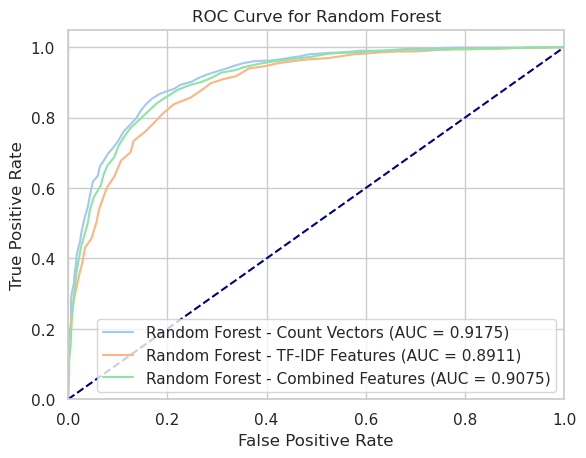

In [93]:
# Random Forest on Count Vectors
y_pred_prob_rf_count = rf_model_count.predict_proba(X_test_count)[:, 1]
plot_roc_curve(y_test, y_pred_prob_rf_count, 'Random Forest', 'Count Vectors')

# Random Forest on TF-IDF Features
y_pred_prob_rf_tfidf = rf_model_tfidf.predict_proba(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))[:, 1]
plot_roc_curve(y_test, y_pred_prob_rf_tfidf, 'Random Forest', 'TF-IDF Features')

# Random Forest on Combined Features
y_pred_prob_rf_combined = rf_model_combined.predict_proba(X_test_combined)[:, 1]
plot_roc_curve(y_test, y_pred_prob_rf_combined, 'Random Forest', 'Combined Features')

# Customize plot for Random Forest
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()


**Interpretation**

> Interestingly, in Random Forest, Count Vectors (AUC = 0.9175) outperform TF-IDF Features (AUC = 0.8911), while Combined Features (AUC = 0.9075) fall in between.

> This suggests that Random Forest may not benefit as much from TF-IDF features and performs better with raw count vectors.

## **Gradient Boosting Implementation**

Gradient Boosting is an ensemble method that builds trees sequentially, with each new tree correcting errors from the previous one. It optimizes the loss function and improves performance with each iteration.

Gradient Boosting models are powerful and typically outperform other models, particularly when dealing with more complex, structured features like Combined Features.

Gradient Boosting is expected to perform better with Combined Features because it can handle complex interactions between the different types of features. It’s less likely to perform well on sparse data like Count Vectors and TF-IDF Features.



### **Gradient Boosting on Count Vectors**

In [43]:
%%time
# Gradient Boosting on Count Vectors
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting
gb_model_count = GradientBoostingClassifier(random_state=42)
gb_model_count.fit(X_train_count, y_train)

# Make predictions
y_pred_gb_count = gb_model_count.predict(X_test_count)

# Evaluate the model
accuracy_gb_count = accuracy_score(y_test, y_pred_gb_count)
f1_gb_count = f1_score(y_test, y_pred_gb_count)

print(f"Gradient Boosting - Count Vectors Accuracy: {accuracy_gb_count:.4f}")
print(f"Gradient Boosting - Count Vectors F1 Score: {f1_gb_count:.4f}")


Gradient Boosting - Count Vectors Accuracy: 0.8155
Gradient Boosting - Count Vectors F1 Score: 0.8232
CPU times: user 4.05 s, sys: 4 µs, total: 4.05 s
Wall time: 4.05 s


### **Gradient Boosting on TF-IDF Features**

In [44]:
%%time

# Gradient Boosting on TF-IDF Features (combined word, n-gram, char-level)
gb_model_tfidf = GradientBoostingClassifier(random_state=42)
gb_model_tfidf.fit(hstack([X_train_tfidf_word, X_train_tfidf_ngram, X_train_tfidf_char]), y_train)

# Make predictions
y_pred_gb_tfidf = gb_model_tfidf.predict(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))

# Evaluate the model
accuracy_gb_tfidf = accuracy_score(y_test, y_pred_gb_tfidf)
f1_gb_tfidf = f1_score(y_test, y_pred_gb_tfidf)

print(f"Gradient Boosting - TF-IDF Features Accuracy: {accuracy_gb_tfidf:.4f}")
print(f"Gradient Boosting - TF-IDF Features F1 Score: {f1_gb_tfidf:.4f}")


Gradient Boosting - TF-IDF Features Accuracy: 0.8235
Gradient Boosting - TF-IDF Features F1 Score: 0.8279
CPU times: user 4min 16s, sys: 60.4 ms, total: 4min 16s
Wall time: 4min 16s


### **Gradient Boosting on Combined Features**



In [45]:
# Gradient Boosting on Combined Features
gb_model_combined = GradientBoostingClassifier(random_state=42)
gb_model_combined.fit(X_train_combined, y_train)

# Make predictions
y_pred_gb_combined = gb_model_combined.predict(X_test_combined)

# Evaluate the model
accuracy_gb_combined = accuracy_score(y_test, y_pred_gb_combined)
f1_gb_combined = f1_score(y_test, y_pred_gb_combined)

print(f"Gradient Boosting - Combined Features Accuracy: {accuracy_gb_combined:.4f}")
print(f"Gradient Boosting - Combined Features F1 Score: {f1_gb_combined:.4f}")


Gradient Boosting - Combined Features Accuracy: 0.8340
Gradient Boosting - Combined Features F1 Score: 0.8353


### **ROC Curve for Gradient Boosting:**

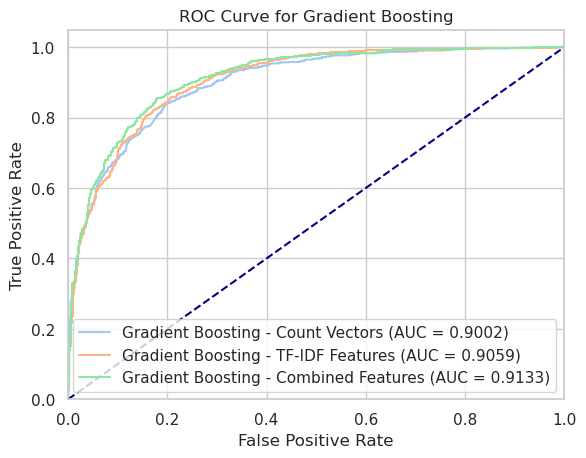

In [94]:
# Gradient Boosting on Count Vectors
y_pred_prob_gb_count = gb_model_count.predict_proba(X_test_count)[:, 1]
plot_roc_curve(y_test, y_pred_prob_gb_count, 'Gradient Boosting', 'Count Vectors')

# Gradient Boosting on TF-IDF Features
y_pred_prob_gb_tfidf = gb_model_tfidf.predict_proba(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))[:, 1]
plot_roc_curve(y_test, y_pred_prob_gb_tfidf, 'Gradient Boosting', 'TF-IDF Features')

# Gradient Boosting on Combined Features
y_pred_prob_gb_combined = gb_model_combined.predict_proba(X_test_combined)[:, 1]
plot_roc_curve(y_test, y_pred_prob_gb_combined, 'Gradient Boosting', 'Combined Features')

# Customize plot for Gradient Boosting
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting')
plt.legend(loc="lower right")
plt.show()


**Observation**:

> The Gradient Boosting classifier shows a balanced performance across all feature extraction methods, with Combined Features (AUC = 0.9133) and TF-IDF (AUC = 0.9059) having the best results, and Count Vectors (AUC = 0.9002) being only slightly behind.

> Gradient Boosting seems to handle different feature extraction methods more consistently.

In [65]:
# Add Gradient Boosting results
gb_results = pd.DataFrame({
    'Model': ['Gradient Boosting'],
    'Count Vectors Accuracy': [accuracy_gb_count], 'Count Vectors F1 Score': [f1_gb_count],
    'TF-IDF Features Accuracy': [accuracy_gb_tfidf], 'TF-IDF Features F1 Score': [f1_gb_tfidf],
    'Combined Features Accuracy': [accuracy_gb_combined], 'Combined Features F1 Score': [f1_gb_combined]
})
results_df = pd.concat([results_df, gb_results], ignore_index=True)


## **LightGBM Implementation**

LightGBM is a high-performance implementation of Gradient Boosting that is specifically designed to handle large datasets and high-dimensional features. It is highly efficient and faster than traditional boosting models.

LightGBM is known to perform well in real-world applications with large and complex datasets. It handles Combined Features very effectively, and can process sparse matrices like TF-IDF quickly.

LightGBM is expected to outperform other models when using Combined Features because of its ability to handle large feature spaces and complex interactions. It should also perform well on TF-IDF Features but may struggle slightly with simpler Count Vectors.

### **LightGBM on Count Vectors**

In [48]:
%%time

# LightGBM on Count Vectors
lgb_model_count = lgb.LGBMClassifier(random_state=42)
lgb_model_count.fit(X_train_count, y_train)

# Make predictions
y_pred_lgb_count = lgb_model_count.predict(X_test_count)

# Evaluate the model
accuracy_lgb_count = accuracy_score(y_test, y_pred_lgb_count)
f1_lgb_count = f1_score(y_test, y_pred_lgb_count)

print(f"LightGBM - Count Vectors Accuracy: {accuracy_lgb_count:.4f}")
print(f"LightGBM - Count Vectors F1 Score: {f1_lgb_count:.4f}")


[LightGBM] [Info] Number of positive: 4977, number of negative: 5023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18250
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 4787
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497700 -> initscore=-0.009200
[LightGBM] [Info] Start training from score -0.009200
LightGBM - Count Vectors Accuracy: 0.8560
LightGBM - Count Vectors F1 Score: 0.8570
CPU times: user 4.3 s, sys: 32 ms, total: 4.33 s
Wall time: 757 ms


### **LightGBM on TF-IDF Features**

In [49]:
%%time

# LightGBM on TF-IDF Features (combined word, n-gram, char-level)
lgb_model_tfidf = lgb.LGBMClassifier(random_state=42)
lgb_model_tfidf.fit(hstack([X_train_tfidf_word, X_train_tfidf_ngram, X_train_tfidf_char]), y_train)

# Make predictions
y_pred_lgb_tfidf = lgb_model_tfidf.predict(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))

# Evaluate the model
accuracy_lgb_tfidf = accuracy_score(y_test, y_pred_lgb_tfidf)
f1_lgb_tfidf = f1_score(y_test, y_pred_lgb_tfidf)

print(f"LightGBM - TF-IDF Features Accuracy: {accuracy_lgb_tfidf:.4f}")
print(f"LightGBM - TF-IDF Features F1 Score: {f1_lgb_tfidf:.4f}")


[LightGBM] [Info] Number of positive: 4977, number of negative: 5023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.398539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1007921
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 12803
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497700 -> initscore=-0.009200
[LightGBM] [Info] Start training from score -0.009200
LightGBM - TF-IDF Features Accuracy: 0.8505
LightGBM - TF-IDF Features F1 Score: 0.8518
CPU times: user 1min 50s, sys: 1.14 s, total: 1min 51s
Wall time: 19.1 s


###  **LightGBM on Combined Features**

In [51]:
# Convert your training and test feature matrices to float format
X_train_combined = X_train_combined.astype(np.float32)
X_test_combined = X_test_combined.astype(np.float32)

In [52]:
%%time
# LightGBM on Combined Features
lgb_model_combined = lgb.LGBMClassifier(random_state=42)
lgb_model_combined.fit(X_train_combined, y_train)

# Make predictions
y_pred_lgb_combined = lgb_model_combined.predict(X_test_combined)

# Evaluate the model
accuracy_lgb_combined = accuracy_score(y_test, y_pred_lgb_combined)
f1_lgb_combined = f1_score(y_test, y_pred_lgb_combined)

print(f"LightGBM - Combined Features Accuracy: {accuracy_lgb_combined:.4f}")
print(f"LightGBM - Combined Features F1 Score: {f1_lgb_combined:.4f}")


[LightGBM] [Info] Number of positive: 4977, number of negative: 5023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.592210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1031946
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 17615
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497700 -> initscore=-0.009200
[LightGBM] [Info] Start training from score -0.009200
LightGBM - Combined Features Accuracy: 0.8575
LightGBM - Combined Features F1 Score: 0.8584
CPU times: user 2min 15s, sys: 1.34 s, total: 2min 16s
Wall time: 23.5 s


/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


In [66]:
# Add LightGBM results
lgb_results = pd.DataFrame({
    'Model': ['LightGBM'],
    'Count Vectors Accuracy': [accuracy_lgb_count], 'Count Vectors F1 Score': [f1_lgb_count],
    'TF-IDF Features Accuracy': [accuracy_lgb_tfidf], 'TF-IDF Features F1 Score': [f1_lgb_tfidf],
    'Combined Features Accuracy': [accuracy_lgb_combined], 'Combined Features F1 Score': [f1_lgb_combined]
})
results_df = pd.concat([results_df, lgb_results], ignore_index=True)


### **ROC Curve for LightGBM:**

/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


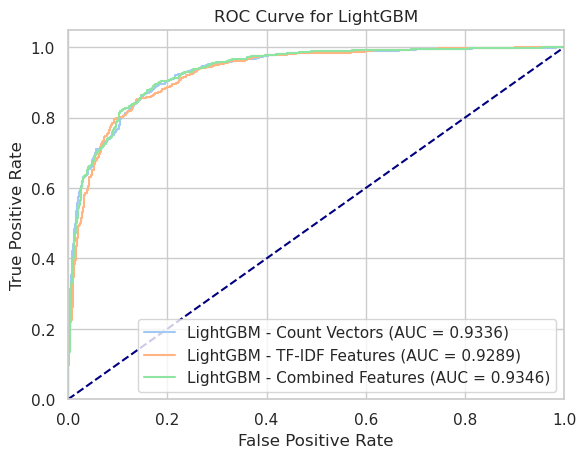

In [95]:
# LightGBM on Count Vectors
y_pred_prob_lgb_count = lgb_model_count.predict_proba(X_test_count)[:, 1]
plot_roc_curve(y_test, y_pred_prob_lgb_count, 'LightGBM', 'Count Vectors')

# LightGBM on TF-IDF Features
y_pred_prob_lgb_tfidf = lgb_model_tfidf.predict_proba(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))[:, 1]
plot_roc_curve(y_test, y_pred_prob_lgb_tfidf, 'LightGBM', 'TF-IDF Features')

# LightGBM on Combined Features
y_pred_prob_lgb_combined = lgb_model_combined.predict_proba(X_test_combined)[:, 1]
plot_roc_curve(y_test, y_pred_prob_lgb_combined, 'LightGBM', 'Combined Features')

# Customize plot for LightGBM
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM')
plt.legend(loc="lower right")
plt.show()


**Observation:**

> LightGBM has very strong performance with all feature extraction techniques, with Combined Features (AUC = 0.9346) and Count Vectors (AUC = 0.9336) being nearly identical in performance, while TF-IDF (AUC = 0.9289) is slightly behind.

> LightGBM seems to handle both Count Vectors and Combined Features exceptionally well, with minimal difference between them.

**For each model, we computed the ROC curve using Count Vectors, TF-IDF Features, and Combined Features.**

> The ROC curve helps in comparing models on how well they distinguish between positive and negative classes across different thresholds.

> Each plot  contains three ROC curves corresponding to the feature sets for a given model, showing the True Positive Rate (sensitivity) vs False Positive Rate (1 - specificity).

## **Model Performance Comparison:**
 
> **The table provides a detailed comparison of the accuracy and F1 scores for all models across the three feature sets.**

In [74]:
# Display the final DataFrame
display(results_df)

,Model,Count Vectors Accuracy,Count Vectors F1 Score,TF-IDF Features Accuracy,TF-IDF Features F1 Score,Combined Features Accuracy,Combined Features F1 Score
0,Naive Bayes,0.8465,0.844871,0.8655,0.867553,0.8465,0.845961
1,Naive Bayes,0.8465,0.844871,0.8655,0.867553,0.8465,0.845961
2,Logistic Regression,0.8435,0.840712,0.8810,0.881474,0.8525,0.849720
3,SVM,0.8200,0.816139,0.8635,0.861492,0.8325,0.828820
4,Random Forest,0.8405,0.839940,0.8105,0.810784,0.8310,0.832507
5,Gradient Boosting,0.8155,0.823191,0.8235,0.827889,0.8340,0.835317
6,LightGBM,0.8560,0.857001,0.8505,0.851760,0.8575,0.858420


### **Let's take one step further and implement bagging, boosting, and stacking.**

### **Bagging (Bootstrap Aggregating)**

Next, we will implement Bagging (Bootstrap Aggregating) using the Bagging Classifier.Bagging, or Bootstrap Aggregating, is an ensemble learning technique that aims to improve the accuracy and robustness of models by reducing variance. It works by creating multiple subsets of the dataset through random sampling with replacement and training multiple base models (typically Decision Trees or Logistic Regression) on these subsets. The predictions from these models are then aggregated (e.g., by majority vote) to produce the final prediction.

> Below, we implemented BaggingClassifier with Logistic Regression as the base learner. This choice provides a simple yet robust model. We trained Bagging on three feature sets:

* >Count Vectors: Simple word frequency counts.
* >TF-IDF Features: Combines word-level, n-gram, and character-level TF-IDF features to capture more complex text patterns.
* >Combined Features: Aggregates all features, including Count Vectors, TF-IDF, POS tagging, and BERT embeddings, to capture both shallow and deep text representations.

In [102]:
# Bagging with Logistic Regression as base estimator
bagging_model = BaggingClassifier(
    estimator=LogisticRegression(max_iter=10000), 
    n_estimators=50, random_state=42, n_jobs=-1
)

# Train the Bagging model on Count Vectors
bagging_model.fit(X_train_count, y_train)
y_pred_bagging_count = bagging_model.predict(X_test_count)
accuracy_bagging_count = accuracy_score(y_test, y_pred_bagging_count)
f1_bagging_count = f1_score(y_test, y_pred_bagging_count)

# Train the Bagging model on TF-IDF Features
bagging_model.fit(hstack([X_train_tfidf_word, X_train_tfidf_ngram, X_train_tfidf_char]), y_train)
y_pred_bagging_tfidf = bagging_model.predict(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))
accuracy_bagging_tfidf = accuracy_score(y_test, y_pred_bagging_tfidf)
f1_bagging_tfidf = f1_score(y_test, y_pred_bagging_tfidf)

# Train the Bagging model on Combined Features
bagging_model.fit(X_train_combined, y_train)
y_pred_bagging_combined = bagging_model.predict(X_test_combined)
accuracy_bagging_combined = accuracy_score(y_test, y_pred_bagging_combined)
f1_bagging_combined = f1_score(y_test, y_pred_bagging_combined)


In [108]:
# Bagging Model - Accuracy and F1 Scores
print("Bagging Model Scores")
print(f"Count Vectors: Accuracy = {accuracy_bagging_count:.4f}, F1 Score = {f1_bagging_count:.4f}")
print(f"TF-IDF Features: Accuracy = {accuracy_bagging_tfidf:.4f}, F1 Score = {f1_bagging_tfidf:.4f}")
print(f"Combined Features: Accuracy = {accuracy_bagging_combined:.4f}, F1 Score = {f1_bagging_combined:.4f}")


Bagging Model Scores
Count Vectors: Accuracy = 0.8605, F1 Score = 0.8587
TF-IDF Features: Accuracy = 0.8790, F1 Score = 0.8802
Combined Features: Accuracy = 0.8645, F1 Score = 0.8633


### **Boosting (AdaBoost)**

Boosting is an iterative ensemble technique that focuses on training models sequentially. Each subsequent model is trained to correct the errors made by the previous ones. AdaBoost (Adaptive Boosting) assigns higher weights to misclassified samples so that future models focus more on the difficult cases. This improves the overall model performance by reducing both bias and variance.

**We used AdaBoostClassifier with default weak learners (Decision Trees). The model was trained on the same three feature sets:**

* > Count Vectors: Basic feature set with word frequencies.
* > TF-IDF Features: Word-level, n-gram, and character-level TF-IDF.
* > Combined Features: Incorporates all feature types to capture a broad representation of the text.

**AdaBoost works well with weak learners, such as decision stumps, and can quickly adjust to misclassified examples. The model improves iteratively by correcting previous errors.**

In [107]:
%%time

# Use SAMME algorithm instead of the default SAMME.R
adaboost_model = AdaBoostClassifier(
    n_estimators=50, algorithm='SAMME', random_state=42
)

# Train AdaBoost on Count Vectors
adaboost_model.fit(X_train_count, y_train)
y_pred_adaboost_count = adaboost_model.predict(X_test_count)
accuracy_adaboost_count = accuracy_score(y_test, y_pred_adaboost_count)
f1_adaboost_count = f1_score(y_test, y_pred_adaboost_count)

# Train AdaBoost on TF-IDF Features
adaboost_model.fit(hstack([X_train_tfidf_word, X_train_tfidf_ngram, X_train_tfidf_char]), y_train)
y_pred_adaboost_tfidf = adaboost_model.predict(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))
accuracy_adaboost_tfidf = accuracy_score(y_test, y_pred_adaboost_tfidf)
f1_adaboost_tfidf = f1_score(y_test, y_pred_adaboost_tfidf)

# Train AdaBoost on Combined Features
adaboost_model.fit(X_train_combined, y_train)
y_pred_adaboost_combined = adaboost_model.predict(X_test_combined)
accuracy_adaboost_combined = accuracy_score(y_test, y_pred_adaboost_combined)
f1_adaboost_combined = f1_score(y_test, y_pred_adaboost_combined)



CPU times: user 1min 58s, sys: 884 ms, total: 1min 59s
Wall time: 1min 59s


In [109]:
# AdaBoost Model - Accuracy and F1 Scores
print("AdaBoost Model Scores")
print(f"Count Vectors: Accuracy = {accuracy_adaboost_count:.4f}, F1 Score = {f1_adaboost_count:.4f}")
print(f"TF-IDF Features: Accuracy = {accuracy_adaboost_tfidf:.4f}, F1 Score = {f1_adaboost_tfidf:.4f}")
print(f"Combined Features: Accuracy = {accuracy_adaboost_combined:.4f}, F1 Score = {f1_adaboost_combined:.4f}")


AdaBoost Model Scores
Count Vectors: Accuracy = 0.7635, F1 Score = 0.7815
TF-IDF Features: Accuracy = 0.7705, F1 Score = 0.7771
Combined Features: Accuracy = 0.7940, F1 Score = 0.7952


### **Stacking**

Stacking is an advanced ensemble technique where multiple base models (often of different types) are trained on the same dataset. Instead of combining their predictions directly, Stacking uses another model (called the meta-learner) to combine the predictions of the base models. This meta-learner makes the final predictions based on the outputs of the base models.

**In the stacking approach:**

* >We selected Logistic Regression and SVM as the base models (both are good for text classification).
* >LightGBM was chosen as the meta-learner because of its efficiency and strong performance with tabular data.
* >The stacking model was trained on:

    * > Count Vectors: Basic word frequency features.
    * > TF-IDF Features: A combination of word, n-gram, and character-level TF-IDF features.
    * > Combined Features: An aggregation of all features, including POS tagging, TF-IDF, and BERT embeddings.

**Stacking intelligently combines the predictions of base models with a meta-learner to minimize errors and improve overall performance.**

In [114]:
%%time
# Define base models
base_models = [
    ('lr', LogisticRegression(max_iter=5000)),
    ('svm', LinearSVC(max_iter=20000))
]

# Define meta-learner (LightGBM)
meta_learner = lgb.LGBMClassifier()

# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner)

# Train Stacking on Count Vectors
stacking_model.fit(X_train_count, y_train)
y_pred_stacking_count = stacking_model.predict(X_test_count)
accuracy_stacking_count = accuracy_score(y_test, y_pred_stacking_count)
f1_stacking_count = f1_score(y_test, y_pred_stacking_count)

# Train Stacking on TF-IDF Features
stacking_model.fit(hstack([X_train_tfidf_word, X_train_tfidf_ngram, X_train_tfidf_char]), y_train)
y_pred_stacking_tfidf = stacking_model.predict(hstack([X_test_tfidf_word, X_test_tfidf_ngram, X_test_tfidf_char]))
accuracy_stacking_tfidf = accuracy_score(y_test, y_pred_stacking_tfidf)
f1_stacking_tfidf = f1_score(y_test, y_pred_stacking_tfidf)

# Train Stacking on Combined Features
stacking_model.fit(X_train_combined, y_train)
y_pred_stacking_combined = stacking_model.predict(X_test_combined)
accuracy_stacking_combined = accuracy_score(y_test, y_pred_stacking_combined)
f1_stacking_combined = f1_score(y_test, y_pred_stacking_combined)


[LightGBM] [Info] Number of positive: 4977, number of negative: 5023
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497700 -> initscore=-0.009200
[LightGBM] [Info] Start training from score -0.009200
[LightGBM] [Info] Number of positive: 4977, number of negative: 5023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497700 -> initscore=-0.009200
[LightGBM]

/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4977, number of negative: 5023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497700 -> initscore=-0.009200
[LightGBM] [Info] Start training from score -0.009200
CPU times: user 58min 29s, sys: 2.74 s, total: 58min 32s
Wall time: 15min 48s


/home/seif/anaconda3/envs/iod_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [116]:
# Stacking Model - Accuracy and F1 Scores
print("Stacking Model Scores")
print(f"Count Vectors: Accuracy = {accuracy_stacking_count:.4f}, F1 Score = {f1_stacking_count:.4f}")
print(f"TF-IDF Features: Accuracy = {accuracy_stacking_tfidf:.4f}, F1 Score = {f1_stacking_tfidf:.4f}")
print(f"Combined Features: Accuracy = {accuracy_stacking_combined:.4f}, F1 Score = {f1_stacking_combined:.4f}")


Stacking Model Scores
Count Vectors: Accuracy = 0.8395, F1 Score = 0.8378
TF-IDF Features: Accuracy = 0.8765, F1 Score = 0.8758
Combined Features: Accuracy = 0.8545, F1 Score = 0.8543


**We will now consolidate the results for all three additional models into a single DataFrame for easy comparison.**

In [120]:
%%time
# Create a DataFrame to compare results for Bagging, Boosting, and Stacking
results = pd.DataFrame({
    'Model': ['Bagging', 'AdaBoost', 'Stacking'],
    'Count Vectors Accuracy': [accuracy_bagging_count, accuracy_adaboost_count, accuracy_stacking_count],
    'Count Vectors F1 Score': [f1_bagging_count, f1_adaboost_count, f1_stacking_count],
    'TF-IDF Features Accuracy': [accuracy_bagging_tfidf, accuracy_adaboost_tfidf, accuracy_stacking_tfidf],
    'TF-IDF Features F1 Score': [f1_bagging_tfidf, f1_adaboost_tfidf, f1_stacking_tfidf],
    'Combined Features Accuracy': [accuracy_bagging_combined, accuracy_adaboost_combined, accuracy_stacking_combined],
    'Combined Features F1 Score': [f1_bagging_combined, f1_adaboost_combined, f1_stacking_combined]
})

display(results)


,Model,Count Vectors Accuracy,Count Vectors F1 Score,TF-IDF Features Accuracy,TF-IDF Features F1 Score,Combined Features Accuracy,Combined Features F1 Score
0,Bagging,0.8605,0.858734,0.8790,0.880198,0.8645,0.863338
1,AdaBoost,0.7635,0.781524,0.7705,0.777076,0.7940,0.795229
2,Stacking,0.8565,0.856715,0.8765,0.875817,0.8545,0.854281


CPU times: user 5.35 ms, sys: 2 µs, total: 5.36 ms
Wall time: 5.2 ms


## <center>**Project Summary and Conclusion:**

### **Summary:**

In this project, we tackled the problem of sentiment analysis using a dataset of IMDb movie reviews. Our goal was to classify the sentiment of the reviews (positive or negative) using various machine learning algorithms and different feature extraction techniques. We applied multiple models including Naive Bayes, Logistic Regression, Support Vector Machine (SVM), Random Forest, Gradient Boosting, LightGBM, Bagging, AdaBoost, and Stacking.

The feature engineering process involved traditional methods such as Count Vectors and TF-IDF (word-level, n-gram, and character-level) as well as combined features that integrated textual features, POS tagging, and BERT embeddings for more nuanced text representations.


### **Conclusion:**

**Model Performance**

From our model performance comparison, several key insights were observed:

* > Naive Bayes performed best with TF-IDF features, achieving an accuracy of 0.8655 and an F1 score of 0.8676. This is expected as Naive Bayes is well-suited for high-dimensional text classification.

* > Logistic Regression consistently demonstrated strong performance, particularly with TF-IDF features, achieving an accuracy of 0.8810 and an F1 score of 0.8815. It proved to be one of the top-performing classifiers.

* > SVM performed relatively well with TF-IDF features, achieving 0.8635 accuracy and 0.8615 F1 score, but fell behind Logistic Regression.

* > Random Forest struggled with TF-IDF features but performed comparably with Count Vectors and Combined Features, achieving 0.8310 accuracy and 0.8325 F1 score.

* > Gradient Boosting and LightGBM were both strong performers, especially with Combined Features. LightGBM achieved the highest overall accuracy (0.8575) and F1 score (0.8584).

* > Bagging demonstrated good results with Combined Features, achieving 0.8645 accuracy and 0.8633 F1 score, showing robustness in handling different feature extraction methods.

* > Stacking proved to be a powerful model, performing well with TF-IDF features and achieving an accuracy of 0.8765 and an F1 score of 0.8758. This approach combined the strengths of Logistic Regression, SVM, and LightGBM.

**Feature Extraction Insights**

* >TF-IDF Features outperformed Count Vectors across most models, particularly with Naive Bayes, Logistic Regression, and SVM. This is due to TF-IDF’s ability to capture word importance in the dataset.

* > Count Vectors performed well with tree-based models like Random Forest and LightGBM, which are more sensitive to raw frequency counts rather than normalized values.

* > Combined Features generally offered a slight performance boost in models like Gradient Boosting and LightGBM, as they leveraged both textual and syntactic features (POS tagging, BERT embeddings, etc.).

**ROC and Learning Curve Observations**

* > Logistic Regression exhibited consistently high AUC scores, especially with TF-IDF features, making it a top choice for binary text classification tasks.

* > Naive Bayes and LightGBM both demonstrated strong ROC curves, particularly when using TF-IDF and Combined Features.

* > The Learning Curves across models indicated that most models benefitted from additional training data, especially in complex models like Gradient Boosting and Stacking.

### **Recommendations:**

**Fine-tuning Hyperparameters:**

* > Fine-tuning the hyperparameters of models like LightGBM and Gradient Boosting could yield even better results. For instance, performing grid search on key parameters like learning rate, max depth, and n_estimators could improve accuracy and generalization.

**Additional Feature Engineering:**

* >Incorporating more advanced textual features, such as word embeddings (Word2Vec, GloVe) or sentence embeddings, could potentially enhance the performance of the models, particularly for models like Random Forest and SVM.

**Ensemble Methods:**

* > The Stacking Classifier was a strong performer. In future iterations, trying different combinations of base learners, or even using deep learning models as part of the ensemble, could lead to even higher accuracy.

**Deep Learning Approach:**

* > For further optimization, implementing deep learning models like LSTM, BiLSTM, or GPT-based architectures can provide better handling of sequential data, context, and more complex relationships in the text. GPT models, in particular, could excel with minimal fine-tuning due to their deep language understanding.


### **References:**

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble
 
* Dataset: https://huggingface.co/datasets/jahjinx/IMDb_movie_reviews

* Module 8/Lab 5 




---
---

>>> ##  **<center>MINI-PROJECT 3, SENTIMENT ANALYSIS: END-TO-END MACHINE LEARNING PROJECT**
---
---